In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier


# Other Libraries
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.display import display

In [2]:
class ProcessData:
    def __init__(self, data_frame: pd.DataFrame, Lable_Colume_Name: str):
        self.df = data_frame
        self.Lable_Colume_Name = Lable_Colume_Name

    def View_Static_Index(self):
        display(self.df.head())
        display(self.df.describe())
        print(self.df.info())
        print("Số lượng giá trị NaN lớn nhất các cột:", self.df.isnull().sum().max())
    
    def Check_Imbalanced(self, dataframe:pd.DataFrame = None):
        if dataframe is None:
            dataframe = self.df

        labels = dataframe[self.Lable_Colume_Name].value_counts()   
        for lable, count_label in labels.items():
            print(f"Nhãn {lable} có {count_label} giá trị - Chiếm {round(count_label/len(dataframe) * 100, 2)}%")
        sns.countplot(x=self.Lable_Colume_Name, data=dataframe)
        return labels
    
    def Scaling_Data(self, *list_lable, mode = {StandardScaler(), RobustScaler(), MinMaxScaler()}):
        Mode_Scaling = mode
        for lable in list_lable:
            self.df[f'scaler_{lable}'] = Mode_Scaling.fit_transform(self.df[lable].values.reshape(-1,1))
            self.df.drop(lable, axis=1,inplace=True)
        return self.df
    
    def Random_Data_OverSampling(self, random_state = None, sampling_strategy='auto'):
        self.df = self.df.sample(frac = 1)
        X = self.df.drop(self.Lable_Colume_Name, axis=1)
        y = self.df[self.Lable_Colume_Name]

        smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        df_resampled[self.Lable_Colume_Name] = y_resampled
        return df_resampled
    
    def Random_Data_UnderSampling(self):
        self.df = self.df.sample(frac = 1)
        count_labels = self.df[self.Lable_Colume_Name].value_counts() 
        min_lable = min(count_labels)

        new_df = pd.DataFrame()
        for lable in count_labels.keys():
            df_lable = self.df.loc[ self.df[self.Lable_Colume_Name] == lable ][:min_lable]
            new_df = pd.concat([new_df,df_lable])
        
        new_df = new_df.sample(frac=1, random_state=42)
        return new_df
    
    def Remove_Outlier_IQR(self, Name_Feature:str, Lable_Value:str, dataframe: pd.DataFrame = None):
        if dataframe is None:
            dataframe = self.df
            
        feature = dataframe[Name_Feature].loc[dataframe[self.Lable_Colume_Name] == Lable_Value].values
        q25 = np.percentile(feature, 25)
        q75 = np.percentile(feature, 75)
        print(f'Quartile 25: {q25} | Quartile 75: {q75}')
        feature_iqr = q75 - q25
        print(f'iqr: {feature_iqr}')

        feature_cut_off = feature_iqr * 1.5
        feature_lower = q25 - feature_cut_off
        feature_upper = q75 + feature_cut_off
        print(f'Cut Off: {feature_cut_off}')
        print(f'{Name_Feature} Lower: {feature_lower}')
        print(f'{Name_Feature} Upper: {feature_upper}')

        outliers = [x for x in feature if x < feature_lower or x > feature_upper]
        print(f'Feature {Name_Feature} Outliers for Fraud Cases: {len(outliers)}')
        print(f'{Name_Feature} outliers:{outliers}')
        
        dataframe = dataframe.drop(dataframe[(dataframe[Name_Feature] > feature_upper) | (dataframe[Name_Feature] < feature_lower)].index)
        print("-"*50)
        return dataframe

In [3]:
class TrainingModel:
    def __init__(self, data_frame: pd.DataFrame, Lable_Colume_Name: str):
        self.df = data_frame
        self.Lable_Colume_Name = Lable_Colume_Name


    def Find_Best_Parameters(self, model, model_para, X_train, y_train):
        # Tìm các siêu tham số tốt nhất cho mô hình bằng phương pháp tìm kiếm ngẫu nhiên
        bayes_model = RandomizedSearchCV(model, model_para, n_iter=5)
        bayes_model.fit(X_train, y_train)
        return bayes_model.best_estimator_

    def Plot_Learning_Curve(self, models, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
        # Vẽ đường học tập của các mô hình trên tập dữ liệu
        fig, ax = plt.subplots(1,7, figsize=(30,20), sharey=True)
        if ylim is not None:
            plt.ylim(*ylim)

            for i, model in enumerate(models.values()):
                train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
                train_scores_mean = np.mean(train_scores, axis=1)
                train_scores_std = np.std(train_scores, axis=1)
                test_scores_mean = np.mean(test_scores, axis=1)
                test_scores_std = np.std(test_scores, axis=1)
                ax[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                                train_scores_mean + train_scores_std, alpha=0.1,
                                color="#ff9124")
                ax[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                                test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
                ax[i].plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
                        label="Training score")
                ax[i].plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
                        label="Cross-validation score")
                ax[i].set_title(model.__class__.__name__, fontsize=14)
                ax[i].set_xlabel('Training size (m)')
                ax[i].set_ylabel('Score')
                ax[i].grid(True)
                ax[i].legend(loc="best")
        return plt
    
    def Run(self):
        X = self.df.drop(self.Lable_Colume_Name, axis=1)
        y = self.df[self.Lable_Colume_Name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values

        # Tổng hợp các model
        classifiers = {
            "LightGBM": LGBMClassifier(force_col_wise=True),  # Thêm LightGBM
            "CatBoost": CatBoostClassifier(),  # Thêm CatBoost
            "RandomForest": RandomForestClassifier(),  # Thêm Random Forest
            "LogisiticRegression": LogisticRegression(max_iter=1000),
            "KNearest": KNeighborsClassifier(n_neighbors=2),
            "Support Vector Classifier": SVC(),
            "DecisionTreeClassifier": DecisionTreeClassifier()
        }

        # Các tham số của từng model để cho vào hàm Find_Best_Parameters và tìm ra model có tham số tốt nhất
        classifiers_parameter = { 
            "LightGBM": {'num_leaves': [31, 50, 100], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5], 'min_child_samples': [20, 50, 100]},
            "LogisiticRegression":{"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
            "KNearest":{"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
            "Support Vector Classifier":{'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
            "DecisionTreeClassifier":{"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))},
            "CatBoost": {'depth': [4, 6, 8],'learning_rate': [0.001, 0.01, 0.1],'iterations': [100, 150, 200]},
            "RandomForest": {'n_estimators': [100, 150, 200],'max_depth': [None, 10, 20],'min_samples_split': [2, 5, 10]}
        }

        # lặp qua từng model trong danh sách trên đê tìm ra tham số tốt nhất và vẽ sơ đồ học
        for key in classifiers.keys():
            model = self.Find_Best_Parameters(classifiers[key], classifiers_parameter[key], X_train, y_train)
            classifiers[key] = model
            training_score = cross_val_score(model, X_train, y_train, cv=5)
            print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

        cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
        # for key in classifiers.keys():
        self.Plot_Learning_Curve(classifiers, X_train, y_train, ylim=(0.87, 1.01), cv=cv, n_jobs=4)
            
        return classifiers

In [4]:
import lime
import shap
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

class ExplainModel:
    def __init__(self, model, X_train, y_train):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.lime_explainer = LimeTabularExplainer(X_train.values, mode="classification", training_labels=y_train)
        self.shap_explainer = shap.Explainer(model,X_train)

    def Apply_Lime(self, sample_data):
        explanation = self.lime_explainer.explain_instance(sample_data, predict_fn=self.model.predict_proba)
        explanation.show_in_notebook()

    # def Apply_Shap(self, sample_data):
    #     shap_values = self.shap_explainer.shap_values(sample_data)
    #     shap.summary_plot(shap_values, sample_data)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# RUN

In [5]:
path = "./creditcard.csv"
df = pd.read_csv(path)

obj = ProcessData(df, "Class")

Nhãn 0 có 284315 giá trị - Chiếm 99.83%
Nhãn 1 có 492 giá trị - Chiếm 0.17%


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Class
0    284315
1       492
Name: count, dtype: int64

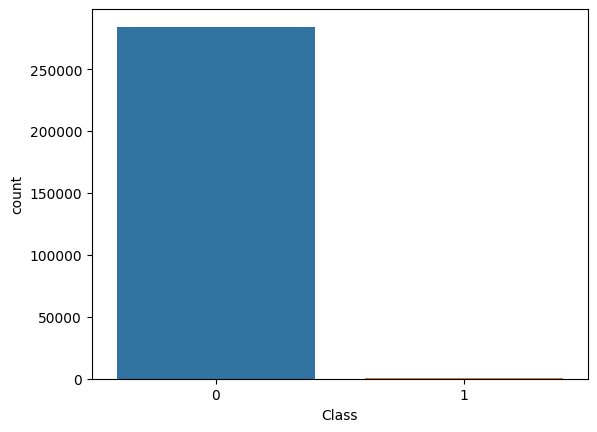

In [6]:
obj.Check_Imbalanced()

In [7]:
df = obj.Scaling_Data("Time", "Amount", mode=RobustScaler())
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaler_Time,scaler_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,-0.994983,1.783274
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.994983,-0.269825
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,-0.994972,4.983721
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,-0.994972,1.418291
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.994960,0.670579


In [8]:
new_df_undersampling = obj.Random_Data_UnderSampling()
new_df_undersampling

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaler_Time,scaler_Amount
154693,-2.488363,4.359019,-7.776410,5.364027,-1.823877,-2.445140,-4.964221,1.484890,-2.947899,-7.175350,...,1.021226,-0.266476,-0.370880,0.365535,0.081372,0.184983,-0.211582,1,0.210611,-0.293440
236356,1.672396,-0.260957,-2.541030,1.461461,0.693230,-1.460122,1.397081,-0.681103,-0.307995,0.286783,...,0.977249,-0.419957,-0.021510,0.794257,-0.211235,-0.092211,-0.041697,0,0.752828,2.808636
192382,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,-3.224559,...,0.033958,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,1,0.528390,-0.279466
185789,2.320023,-0.452865,-2.458738,-0.865100,0.117580,-1.895096,0.440337,-0.667652,-0.920687,0.970585,...,1.383774,-0.231477,-0.029191,0.759411,0.310686,-0.099591,-0.097413,0,0.494978,-0.237546
66766,0.945462,-0.481862,1.245731,1.708175,-0.980634,0.764107,-0.723109,0.527021,1.293738,-0.204008,...,-0.762215,0.087784,0.162980,0.282229,-0.536271,0.066655,0.022760,0,-0.381583,0.385663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198862,-1.112686,-0.318466,1.821959,-0.364801,-1.012982,0.437547,1.616626,-0.029152,0.029031,-0.851341,...,-0.386874,0.493520,-0.111092,0.269443,-0.461568,-0.216432,-0.138210,0,0.563834,4.347516
272780,2.056469,-0.030529,-1.068374,0.398941,-0.065616,-1.105744,0.194736,-0.329038,0.484140,0.053896,...,-0.648669,0.339690,-0.028136,-0.297006,0.201407,-0.065008,-0.060023,0,0.946592,-0.289387
8842,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,-4.594952,...,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,1,-0.852912,-0.307413
176272,-0.570133,1.940053,1.024762,3.852049,1.285078,1.489999,0.680551,0.240251,-2.231323,1.956070,...,0.398994,-0.677763,-1.356858,0.800071,0.755175,0.424284,0.173195,0,0.446493,-0.307413


In [9]:
new_df_oversampling = obj.Random_Data_OverSampling()
new_df_oversampling

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaler_Time,scaler_Amount,Class
0,-2.482386,-2.689306,1.616252,-0.675777,2.095449,-1.485410,-1.693325,0.072568,-0.967079,0.400063,...,0.839133,-0.133055,-0.615964,0.758863,0.247224,-0.287735,0.591806,0.339513,-0.028645,0
1,1.921243,-0.440874,-1.745608,0.450669,2.093568,4.158399,-0.887274,1.082918,1.023458,0.007452,...,-1.335135,0.477909,0.616452,-0.281896,-1.084363,0.073983,-0.036804,0.661403,-0.202753,0
2,-1.406415,0.312893,1.964883,1.126989,-1.466154,0.845150,0.589037,0.651796,-0.322183,-1.036387,...,0.340196,0.435477,0.036038,0.271907,-0.242060,-0.075857,0.046186,-0.087043,3.549221,0
3,1.124838,-0.818049,1.372617,-0.141179,-1.437545,0.463830,-1.268234,0.281016,-0.716717,0.784719,...,0.401248,0.011383,0.061555,0.009857,0.476687,0.056907,0.034166,-0.621377,0.475093,0
4,1.224003,-1.811495,1.438418,-1.164996,-2.325394,0.512558,-1.944793,0.286897,-0.939769,1.328350,...,0.664675,-0.180430,0.047871,0.294730,0.015764,0.085496,0.040443,-0.422127,1.173059,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-2.353391,2.882379,-4.917442,3.563371,-3.517961,-0.818033,-4.370336,0.522460,-2.309408,-4.674964,...,0.444479,0.050862,0.039884,-0.271311,0.143892,0.316069,-0.061566,0.013694,1.866408,1
568626,-5.007450,2.765921,-5.439110,5.388419,-2.787708,-1.306983,-5.172764,1.335936,-1.018112,-4.499378,...,0.368049,0.587217,-0.196027,-0.691459,-0.205993,-1.412059,0.691177,-0.547119,-0.094765,1
568627,0.656879,2.878736,-5.443789,6.051435,-0.393829,-1.929842,-2.787954,0.530709,-3.232142,-4.458722,...,-0.676382,0.018896,-0.406923,0.323688,-0.003677,0.838468,0.422934,0.854491,-0.248745,1
568628,-20.790781,12.480124,-23.216890,6.155982,-15.754910,-4.398874,-16.049804,13.856485,-3.938645,-8.763218,...,-1.487659,-0.874740,0.127451,1.422527,-0.223549,1.565352,0.466248,-0.679608,1.089779,1


Nhãn 1 có 492 giá trị - Chiếm 50.0%
Nhãn 0 có 492 giá trị - Chiếm 50.0%


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Class
1    492
0    492
Name: count, dtype: int64

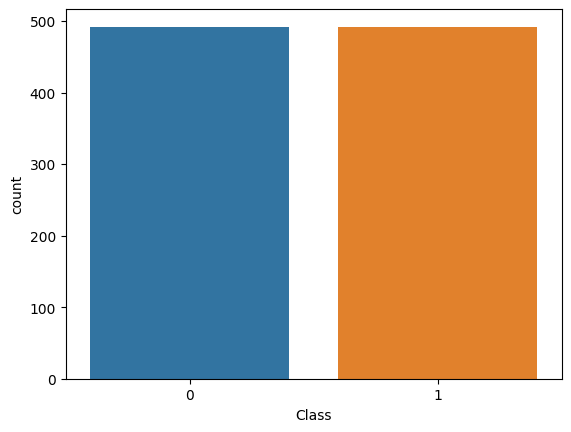

In [10]:
obj.Check_Imbalanced(new_df_undersampling)

Nhãn 0 có 284315 giá trị - Chiếm 50.0%
Nhãn 1 có 284315 giá trị - Chiếm 50.0%


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Class
0    284315
1    284315
Name: count, dtype: int64

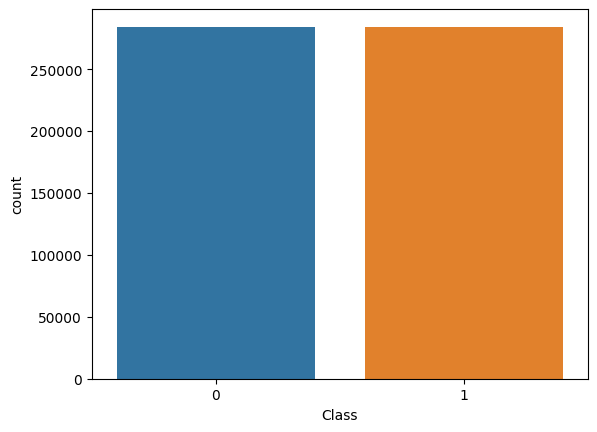

In [11]:
obj.Check_Imbalanced(new_df_oversampling)

In [12]:
list_feature = ['V14', 'V12', 'V10']
for fe in list_feature:
    new_df_undersampling = obj.Remove_Outlier_IQR(fe, 1, new_df_undersampling)

new_df_undersampling

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.0499976898594, -18.8220867423816, -18.4937733551053, -19.2143254902614]
--------------------------------------------------
Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
Cut Off: 8.670003953572252
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
Feature V12 Outliers for Fraud Cases: 4
V12 outliers:[-18.4311310279993, -18.6837146333443, -18.5536970096458, -18.0475965708216]
--------------------------------------------------
Quartile 25: -7.466658535821847 | Quartile 75: -2.5118611381562523
iqr: 4.954797397665595
Cut Off: 7.432196096498393
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
Feature V10 Outliers for Fraud Cases: 27
V10 outliers:[-15.2399619587112, -19.836148851696, -22.1870885620007, -1

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaler_Time,scaler_Amount
154693,-2.488363,4.359019,-7.776410,5.364027,-1.823877,-2.445140,-4.964221,1.484890,-2.947899,-7.175350,...,1.021226,-0.266476,-0.370880,0.365535,0.081372,0.184983,-0.211582,1,0.210611,-0.293440
236356,1.672396,-0.260957,-2.541030,1.461461,0.693230,-1.460122,1.397081,-0.681103,-0.307995,0.286783,...,0.977249,-0.419957,-0.021510,0.794257,-0.211235,-0.092211,-0.041697,0,0.752828,2.808636
192382,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,-1.567514,-3.224559,...,0.033958,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,1,0.528390,-0.279466
185789,2.320023,-0.452865,-2.458738,-0.865100,0.117580,-1.895096,0.440337,-0.667652,-0.920687,0.970585,...,1.383774,-0.231477,-0.029191,0.759411,0.310686,-0.099591,-0.097413,0,0.494978,-0.237546
66766,0.945462,-0.481862,1.245731,1.708175,-0.980634,0.764107,-0.723109,0.527021,1.293738,-0.204008,...,-0.762215,0.087784,0.162980,0.282229,-0.536271,0.066655,0.022760,0,-0.381583,0.385663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198862,-1.112686,-0.318466,1.821959,-0.364801,-1.012982,0.437547,1.616626,-0.029152,0.029031,-0.851341,...,-0.386874,0.493520,-0.111092,0.269443,-0.461568,-0.216432,-0.138210,0,0.563834,4.347516
272780,2.056469,-0.030529,-1.068374,0.398941,-0.065616,-1.105744,0.194736,-0.329038,0.484140,0.053896,...,-0.648669,0.339690,-0.028136,-0.297006,0.201407,-0.065008,-0.060023,0,0.946592,-0.289387
8842,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,-4.594952,...,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,1,-0.852912,-0.307413
176272,-0.570133,1.940053,1.024762,3.852049,1.285078,1.489999,0.680551,0.240251,-2.231323,1.956070,...,0.398994,-0.677763,-1.356858,0.800071,0.755175,0.424284,0.173195,0,0.446493,-0.307413


In [13]:
list_feature = ['V14', 'V12', 'V10']
for fe in list_feature:
    new_df_oversampling = obj.Remove_Outlier_IQR(fe, 1, new_df_oversampling)

new_df_oversampling

Quartile 25: -9.712749625873782 | Quartile 75: -4.428770560595318
iqr: 5.283979065278464
Cut Off: 7.925968597917696
V14 Lower: -17.63871822379148
V14 Upper: 3.497198037322378
Feature V14 Outliers for Fraud Cases: 3201
V14 outliers:[-18.0499976898594, -18.4937733551053, -18.8220867423816, -19.2143254902614, -17.7216383537133, -17.704703173561175, -18.53985417976335, -17.84148175059626, -18.64913517603325, -17.98036397027746, -18.608771221368542, -17.67400754204461, -19.16597483193056, -17.883247748641754, -18.762753367518037, -18.963524837267855, -18.989598416274003, -18.088318148820687, -18.43668803316803, -18.28162293037377, -18.68391021240007, -18.038434570877, -17.68144016161986, -18.04826080285331, -19.050506213437323, -18.217600338092517, -18.560194991189167, -17.81125388681547, -18.356858121789347, -18.51418553093852, -17.673489629829884, -18.178406020640438, -18.580812023367045, -18.700418647960458, -18.988950058277773, -19.206080917832676, -18.562238467731824, -19.2048132805254

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,scaler_Time,scaler_Amount,Class
0,-2.482386,-2.689306,1.616252,-0.675777,2.095449,-1.485410,-1.693325,0.072568,-0.967079,0.400063,...,0.839133,-0.133055,-0.615964,0.758863,0.247224,-0.287735,0.591806,0.339513,-0.028645,0
1,1.921243,-0.440874,-1.745608,0.450669,2.093568,4.158399,-0.887274,1.082918,1.023458,0.007452,...,-1.335135,0.477909,0.616452,-0.281896,-1.084363,0.073983,-0.036804,0.661403,-0.202753,0
2,-1.406415,0.312893,1.964883,1.126989,-1.466154,0.845150,0.589037,0.651796,-0.322183,-1.036387,...,0.340196,0.435477,0.036038,0.271907,-0.242060,-0.075857,0.046186,-0.087043,3.549221,0
3,1.124838,-0.818049,1.372617,-0.141179,-1.437545,0.463830,-1.268234,0.281016,-0.716717,0.784719,...,0.401248,0.011383,0.061555,0.009857,0.476687,0.056907,0.034166,-0.621377,0.475093,0
4,1.224003,-1.811495,1.438418,-1.164996,-2.325394,0.512558,-1.944793,0.286897,-0.939769,1.328350,...,0.664675,-0.180430,0.047871,0.294730,0.015764,0.085496,0.040443,-0.422127,1.173059,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,-2.353391,2.882379,-4.917442,3.563371,-3.517961,-0.818033,-4.370336,0.522460,-2.309408,-4.674964,...,0.444479,0.050862,0.039884,-0.271311,0.143892,0.316069,-0.061566,0.013694,1.866408,1
568626,-5.007450,2.765921,-5.439110,5.388419,-2.787708,-1.306983,-5.172764,1.335936,-1.018112,-4.499378,...,0.368049,0.587217,-0.196027,-0.691459,-0.205993,-1.412059,0.691177,-0.547119,-0.094765,1
568627,0.656879,2.878736,-5.443789,6.051435,-0.393829,-1.929842,-2.787954,0.530709,-3.232142,-4.458722,...,-0.676382,0.018896,-0.406923,0.323688,-0.003677,0.838468,0.422934,0.854491,-0.248745,1
568628,-20.790781,12.480124,-23.216890,6.155982,-15.754910,-4.398874,-16.049804,13.856485,-3.938645,-8.763218,...,-1.487659,-0.874740,0.127451,1.422527,-0.223549,1.565352,0.466248,-0.679608,1.089779,1


# Run class training

[LightGBM] [Info] Number of positive: 289, number of negative: 315
[LightGBM] [Info] Total Bins 6044
[LightGBM] [Info] Number of data points in the train set: 604, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478477 -> initscore=-0.086146
[LightGBM] [Info] Start training from score -0.086146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

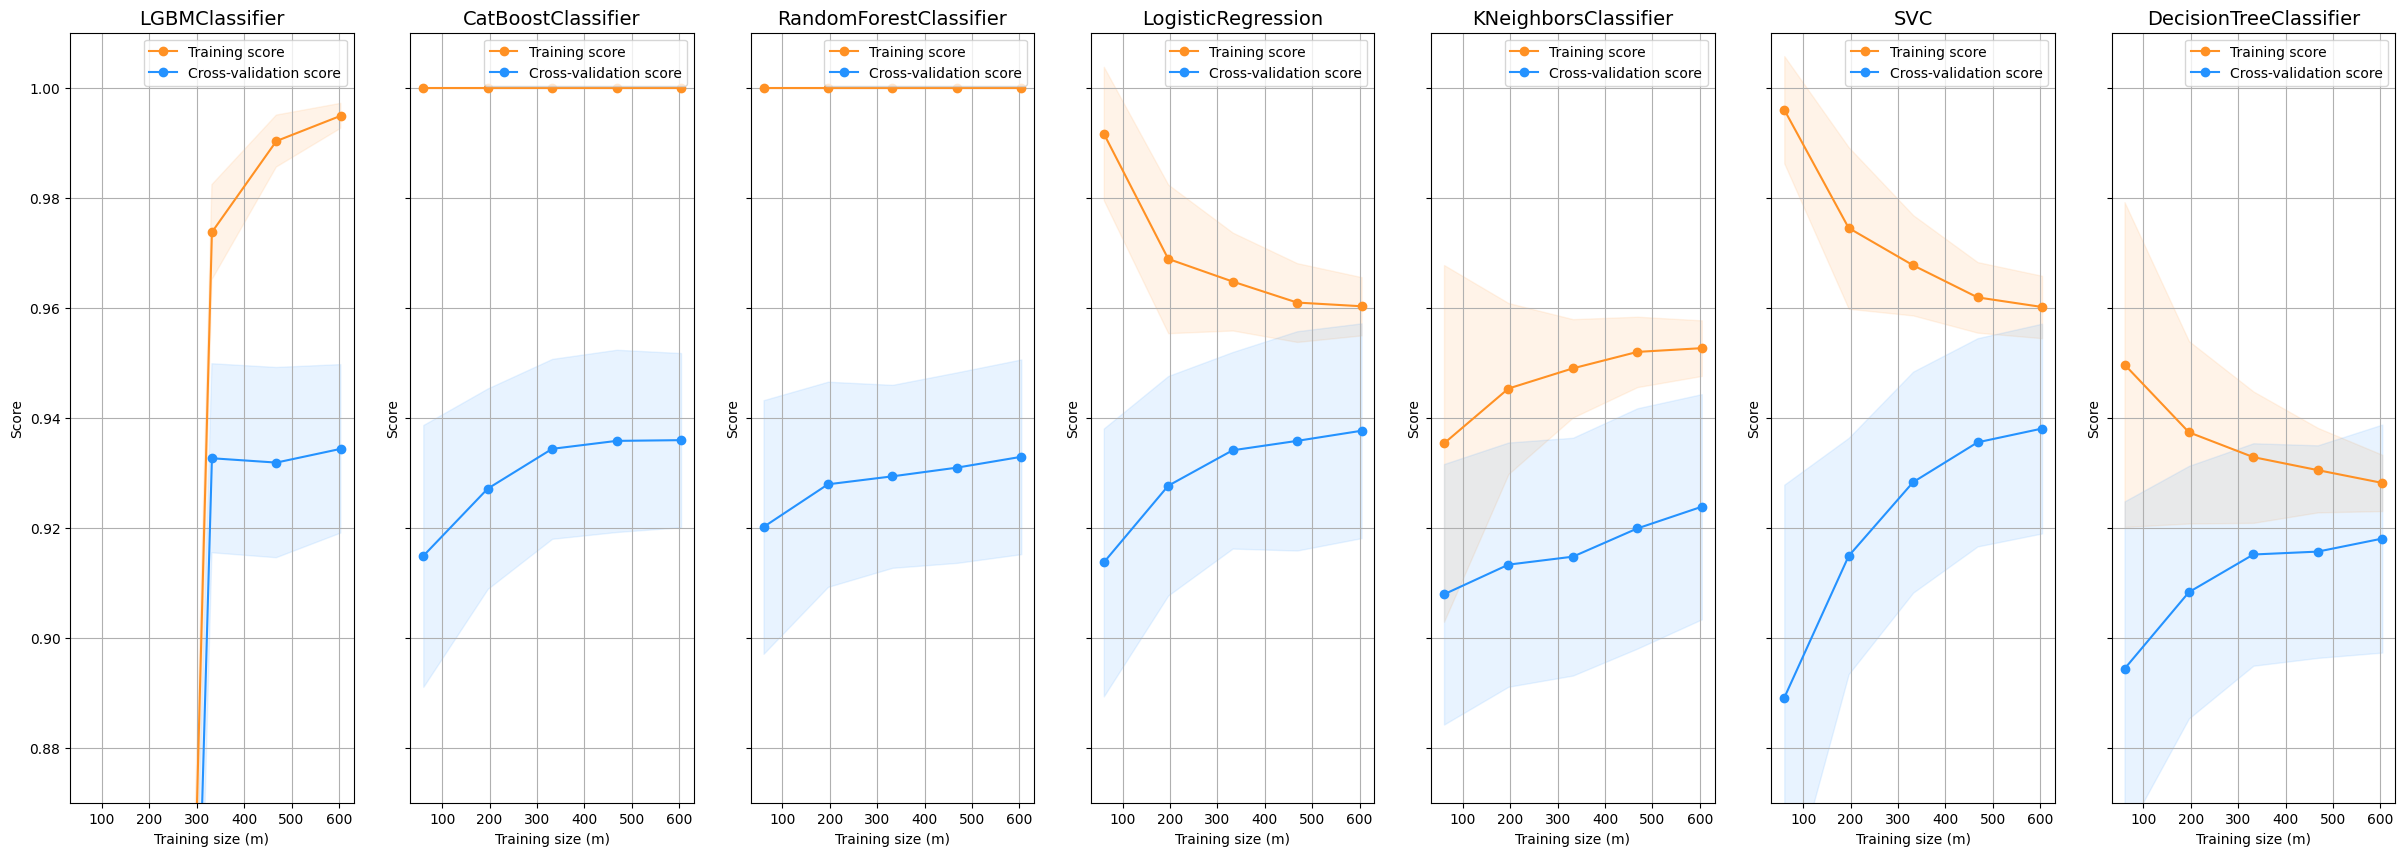

In [14]:
obj_model = TrainingModel(new_df_undersampling, 'Class')
models_undersampling = obj_model.Run()

In [15]:
models_undersampling

{'LightGBM': LGBMClassifier(force_col_wise=True, max_depth=4, min_child_samples=100,
                num_leaves=100),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x236af6ac810>,
 'RandomForest': RandomForestClassifier(max_depth=20, n_estimators=150),
 'LogisiticRegression': LogisticRegression(C=1, max_iter=1000),
 'KNearest': KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2),
 'Support Vector Classifier': SVC(C=0.7, kernel='linear'),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)}

In [16]:
# obj_model = TrainingModel(new_df_oversampling, 'Class')
# models_oversampling = obj_model.Run()

In [17]:
X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

y_predict = models_undersampling['LogisiticRegression'].predict(X_test)
print(classification_report(y_predict, y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     54708
           1       0.93      0.04      0.08      2254

    accuracy                           0.96     56962
   macro avg       0.95      0.52      0.53     56962
weighted avg       0.96      0.96      0.94     56962



X has feature names, but LogisticRegression was fitted without feature names


In [18]:
obj_ex = ExplainModel(models_undersampling['LogisiticRegression'], X_train, y_train)
obj_ex.Apply_Lime(X_test.iloc[1])

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels